In [1]:
# Handling data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Misc
import datetime
from ast import literal_eval

In [2]:
df = pd.read_csv('data.csv')
df = df.drop(df.columns[0], axis=1)

In [3]:
df.shape

(3368, 20)

In [4]:
df.tags = df.tags.str.lower()

In [5]:
df.columns

Index(['id', 'title', 'genre', 'original_price', 'discounted_price',
       'release_date', 'developer', 'publisher', 'overall_rating',
       'overall_vote_count', 'recent_rating', 'recent_vote_count',
       'metacritic_score', 'tags', 'awards', 'description', 'platforms',
       'minimum_requirements', 'recommended_requirements', 'similar_games'],
      dtype='object')

# Data Preparation

#### Dropping duplicates

In [6]:
df = df.drop_duplicates()
df.shape

(3368, 20)

#### Dropping games with few reviews

In [7]:
df = df[~df.overall_vote_count.str.contains('Need more user reviews')]
df = df[~df.overall_rating.str.contains('review')]
df.shape

(3312, 20)

#### Dropping demos

In [8]:
df = df[(df.original_price.str.contains('₹')) | (df.original_price == 'Free')]
df.shape

(3252, 20)

#### Converting prices to float

In [9]:
def convert_price(price):
    try:
        if price == 'Free':
            return 0
        else:
            return float(price.replace(',', '').split()[-1])
    except:
        return -1

In [10]:
df['original_price'] = df['original_price'].apply(convert_price) 
df['discounted_price'] = df['discounted_price'].apply(convert_price)

#### Converting rating text to int

In [11]:
rating_encoder = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Mostly Negative': 2,
    'Negative': 3,
    'Mixed': 4, 
    'Positive': 5,
    'Mostly Positive': 6,
    'Very Positive': 7,
    'Overwhelmingly Positive': 8
}

def label_encode_rating(rating):
    return rating_encoder[rating]

In [12]:
df.overall_rating = df.overall_rating.apply(label_encode_rating)
df.recent_rating = df.recent_rating.apply(label_encode_rating)

df.overall_vote_count = df.overall_vote_count.apply(int)
df.recent_vote_count = df.recent_vote_count.apply(int)

#### Collecting unique tags

In [13]:
tag_set = set()
for tag_list in df.tags.values:
    for tag in eval(tag_list):
        tag_set.add(tag)
        
len(list(tag_set))

402

#### Converting release_date to datetime

In [14]:
def convert_date(date_str):
    try:
        return datetime.datetime.strptime(date_str.replace(',', ''), '%d %b %Y').date()
    except:
        return 0

In [15]:
df.release_date = df.release_date.apply(convert_date)
df = df[df.release_date != 0]
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Add score based on rating and vote count

((v / v + m) * R) + ((m / v + m) * C)

In [16]:
df['overall_rating'].mean()

6.3849953689410315

In [17]:
def calculate_score(overall_rating, vote_count, min_votes=1000):
    # R -> Average rating of game
    # C -> Average rating across the entire dataframe

    C = 6
    R = overall_rating
    
    return (vote_count / (vote_count + min_votes)) * R + (min_votes / (vote_count + min_votes)) * C

In [18]:
df['overall_score'] = df.apply(lambda x: calculate_score(x['overall_rating'], x['overall_vote_count']), axis=1)

## Converting tags from string to list

In [19]:
def convert_to_list(x):
    arr = []
    for i in x[1: -1].split(', '):
        arr.append(i[1: -1])
    return arr


In [20]:
def convert_to_list_2(x):
    arr = []
    for i in x[1: -1].split(', '):
        arr.append(int(i))
    return arr


In [21]:
df['tags'] = df.tags.apply(convert_to_list)
df['similar_games'] = df.similar_games.apply(convert_to_list_2)

# Analysis

### Top 25 games of all time

In [22]:
df[['title', 'overall_score']].sort_values('overall_score', ascending=False)[: 25]

,title,overall_score
153,Terraria,7.939898
1037,Helltaker,7.939017
359,The Witcher® 3: Wild Hunt,7.853919
214,Garry's Mod,7.849703
724,Persona 4 Golden,7.826975
350,Euro Truck Simulator 2,7.784831
572,Monster Train,7.693674
18,Left 4 Dead 2,7.674585
880,Stardew Valley,7.669640
432,Satisfactory,7.652174


# Similar Games

In [23]:
def get_similarity_score(game_id, comparison_id):
    
    game_1 = df[df.id == game_id]
    game_2 = df[df.id == comparison_id]
    
    length = len(game_1.tags.values[0])
    cnt = 0
    
    for tag in game_1.tags.values[0]:
        if tag in game_2.tags.values[0]:
            cnt += 1
            
    score_diff = game_1.overall_score.values - game_2.overall_score.values
    
    return (cnt / length), score_diff[0]


In [24]:
def check_threshold(tag_score, score_diff, tag_cutoff=0.7, score_cutoff=1):
    if tag_score >= tag_cutoff:
        if score_diff <= score_cutoff:
            return True

In [25]:
def get_game_titles(arr):
    for g_id in arr:
        print(df[['title', 'id']][df.id == g_id].values)

In [26]:
game_id = 939960
game_df = df[df.id == game_id]
game_df

,id,title,genre,original_price,discounted_price,release_date,developer,publisher,overall_rating,overall_vote_count,...,recent_vote_count,metacritic_score,tags,awards,description,platforms,minimum_requirements,recommended_requirements,similar_games,overall_score
147,939960,Far Cry® New Dawn,Action,2249.0,2249.0,2019-02-15,"Ubisoft Montreal, Ubisoft Kiev, Ubisoft Shanghai",Ubisoft,6,332,...,9979,0,"[open world, action, fps, post-apocalyptic, ad...",NaN,NaN,['win'],"['OS: Windows 7 SP1, Windows 8.1, Windows 10 (...","['OS: Windows 7 SP1, Windows 8.1, Windows 10 (...","[552520, 412020, 377160, 704270, 397540, 59465...",6.0


In [27]:
arr = []

for compare_id in df.id:
    tag_score, score_diff = get_similarity_score(game_id, compare_id)
    if check_threshold(tag_score, score_diff, 0.6, 1.35):
        arr.append(compare_id)

In [28]:
get_game_titles(arr)

[["Tom Clancy's Ghost Recon® Wildlands" 460930]]
[['Rust' 252490]]
[['Left 4 Dead' 500]]
[['Dying Light' 239140]]
[['Arizona Sunshine' 342180]]
[['Borderlands 2' 49520]]
[['Borderlands: The Pre-Sequel' 261640]]
[['theHunter Classic' 253710]]
[['Far Cry® 5' 552520]]
[['Generation Zero' 704270]]
[['Tom Clancy’s The Division™' 365590]]
[['Defiance' 224600]]
[['Far Cry® 4' 298110]]
[['Far Cry® New Dawn' 939960]]
[['Dead Island Definitive Edition' 383150]]
[['Metro Exodus' 412020]]
[['Fallout 4' 377160]]
[['Far Cry 3' 220240]]
[['Far Cry® Primal' 371660]]
[['Digimon Masters Online' 537180]]
[['Bulletstorm: Full Clip Edition' 501590]]
[["Assassin's Creed® Unity" 289650]]
[['Subsistence' 418030]]
[['Fallout 4 VR' 611660]]
[['S.T.A.L.K.E.R.: Call of Pripyat' 41700]]
[['Sanctum 2' 210770]]
[['Walking Zombie 2' 965200]]
[['E.Y.E: Divine Cybermancy' 91700]]
[['Unturned' 304930]]
[['Wasteland Survival' 1044200]]
[['Tom Clancy’s Splinter Cell Blacklist' 235600]]


In [29]:
get_game_titles(game_df.similar_games.values[0])

[['Far Cry® 5' 552520]]
[['Metro Exodus' 412020]]
[['Fallout 4' 377160]]
[['Generation Zero' 704270]]
[['Borderlands 3' 397540]]
[['Hunt: Showdown' 594650]]
[]
[['Far Cry® 4' 298110]]
[]
[['Rust' 252490]]
[['Borderlands 2' 49520]]
[['Left 4 Dead 2' 550]]
[['Destiny 2' 1085660]]
[['Far Cry 3' 220240]]
[['Arma 3' 107410]]
[['DayZ' 221100]]
[["Tom Clancy's Ghost Recon® Wildlands" 460930]]
[['Call of Duty®: Black Ops II' 202970]]


In [30]:
get_similarity_score(game_id, 220240)

(0.7, -0.42726231386025226)

# Most popular games per genre

In [31]:
for genre in df.genre.unique():
    print(f"-----{genre}-----")
    g_df = df[['title', 'original_price', 'overall_score']][df.genre == genre].sort_values(by='overall_score', ascending=False)
    print(g_df[: 5])
    print("\n\n")

-----Action-----
               title  original_price  overall_score
153         Terraria           369.0       7.939898
18     Left 4 Dead 2           349.0       7.674585
53       Dying Light          1000.0       7.647266
156       The Forest           529.0       7.583160
173  DARK SOULS™ III          4299.0       7.570631



-----Free to Play-----
                            title  original_price  overall_score
243  GWENT: The Witcher Card Game             0.0       6.844624
309             Crusader Kings II             0.0       6.524489
75           Yu-Gi-Oh! Duel Links             0.0       6.480519
422               Fallout Shelter             0.0       6.459459
114                Fishing Planet             0.0       6.396864



-----Simulation-----
                    title  original_price  overall_score
347  Farming Simulator 19           899.0       7.072356
436            Brick Rigs           479.0       6.758535
97      Hearts of Iron IV           849.0       6.718943
317

In [63]:
for year in sorted(df.release_date.dt.year.unique()):
#     print(f"-----{year}-----")
    d = df[['title', 'overall_score']][df.release_date.dt.year == year].sort_values('overall_score', ascending=False)
#     print(d[: 5].values)
#     print("\n\n")

# Popularity of genres over the years

In [76]:
genre_counter = {}

for genre in df.genre.unique():
    genre_counter[genre] = []
    temp_df = df[df.genre == genre]
    
    for year in sorted(df.release_date.dt.year.unique()):
        c = temp_df['genre'][temp_df.release_date.dt.year == year].count()
        genre_counter[genre].append(c)

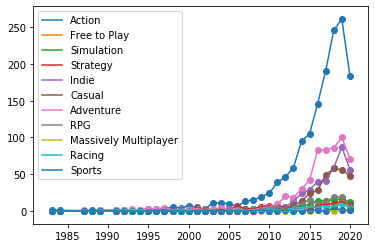

In [96]:
dates = sorted(df.release_date.dt.year.unique())
g_keys = list(genre_counter.keys())
for genre in g_keys:
    y_axis = genre_counter[genre]
    plt.plot(dates, y_axis)
    plt.scatter(dates, y_axis)
    plt.legend(g_keys)